### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [ ]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 55.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Download dataset from Roboflow Universe

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0YEk3IifBtMl3xP65rAW")
project = rf.workspace("beincom").project("ppe-rigs-pdsi-szkiq")
version = project.version(1)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ppe-rigs-pdsi-1 in yolov12:: 100%|██████████| 5852/5852 [00:02<00:00, 2672.71it/s]


In [ ]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [ ]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [ ]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 11
names: ['boots', 'gloves', 'goggles', 'helmet', 'no-helm', 'no_glove', 'no_goggles', 'no_helmet', 'no_shoes', 'person', 'vest']

roboflow:
  workspace: beincom
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov12m.pt')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=10)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 38.0M/38.0M [00:00<00:00, 108MB/s]


New https://pypi.org/project/ultralytics/8.3.114 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12m.pt, data=/content/ppe-rigs-pdsi-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

100%|██████████| 755k/755k [00:00<00:00, 18.2MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2, 1, 2]         
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    147968  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2, 1, 4]        
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2664960  ultralytics.nn.modules.block.A2C2f           [512, 512, 2, True, 4]        
  7                  -1  1   2360320  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 112MB/s]


AMP: checks passed ✅


train: Scanning /content/ppe-rigs-pdsi-1/train/labels... 2119 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2119/2119 [00:00<00:00, 2272.81it/s]

train: New cache created: /content/ppe-rigs-pdsi-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/ppe-rigs-pdsi-1/valid/labels... 657 images, 0 backgrounds, 0 corrupt: 100%|██████████| 657/657 [00:00<00:00, 1037.92it/s]


val: New cache created: /content/ppe-rigs-pdsi-1/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 131 weight(decay=0.0), 138 weight(decay=0.0005), 137 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      12.4G      1.457       1.96      1.454         43        640: 100%|██████████| 133/133 [02:08<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:14<00:00,  1.45it/s]

                   all        657       3750      0.618      0.406      0.428      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10        12G      1.479      1.444      1.444         32        640: 100%|██████████| 133/133 [02:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:13<00:00,  1.55it/s]

                   all        657       3750      0.462      0.398      0.382      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      12.1G      1.459      1.382      1.449         32        640: 100%|██████████| 133/133 [02:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

                   all        657       3750      0.575      0.384       0.43      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10        12G       1.43      1.271      1.422         45        640: 100%|██████████| 133/133 [02:06<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

                   all        657       3750      0.612      0.419      0.442      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10        12G      1.354      1.127      1.362         32        640: 100%|██████████| 133/133 [02:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]

                   all        657       3750      0.604      0.461      0.503      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      12.1G      1.307      1.044      1.325         26        640: 100%|██████████| 133/133 [02:05<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

                   all        657       3750      0.701      0.476      0.518       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10        12G      1.245     0.9615      1.277         71        640: 100%|██████████| 133/133 [02:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

                   all        657       3750      0.735      0.492      0.543      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10        12G      1.174     0.8683      1.233         29        640: 100%|██████████| 133/133 [02:06<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

                   all        657       3750      0.638       0.52      0.558      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      12.1G      1.135     0.8078      1.204         37        640: 100%|██████████| 133/133 [02:05<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]

                   all        657       3750      0.639       0.51      0.567      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10        12G      1.085      0.738      1.177         21        640: 100%|██████████| 133/133 [02:05<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

                   all        657       3750      0.749      0.531       0.59      0.387



10 epochs completed in 0.404 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 39.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 39.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 402 layers, 19,585,009 parameters, 0 gradients, 59.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


                   all        657       3750      0.749      0.531       0.59      0.387
                 boots        411        953      0.884      0.865      0.928      0.659
                gloves        126        207      0.694      0.469      0.564      0.344
               goggles         16         33          1          0     0.0995     0.0422
                helmet        490        780      0.865      0.876      0.928      0.655
               no-helm          3          3          0          0          0          0
              no_glove         70        231      0.569      0.511       0.52       0.21
            no_goggles         71        215      0.729      0.488      0.561      0.204
             no_helmet         35        187      0.778      0.754      0.826      0.496
              no_shoes          6         15          1          0      0.137     0.0521
                person        382        452      0.803      0.914      0.952      0.843
                  ves

## Evaluate fine-tuned YOLOv12 model

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

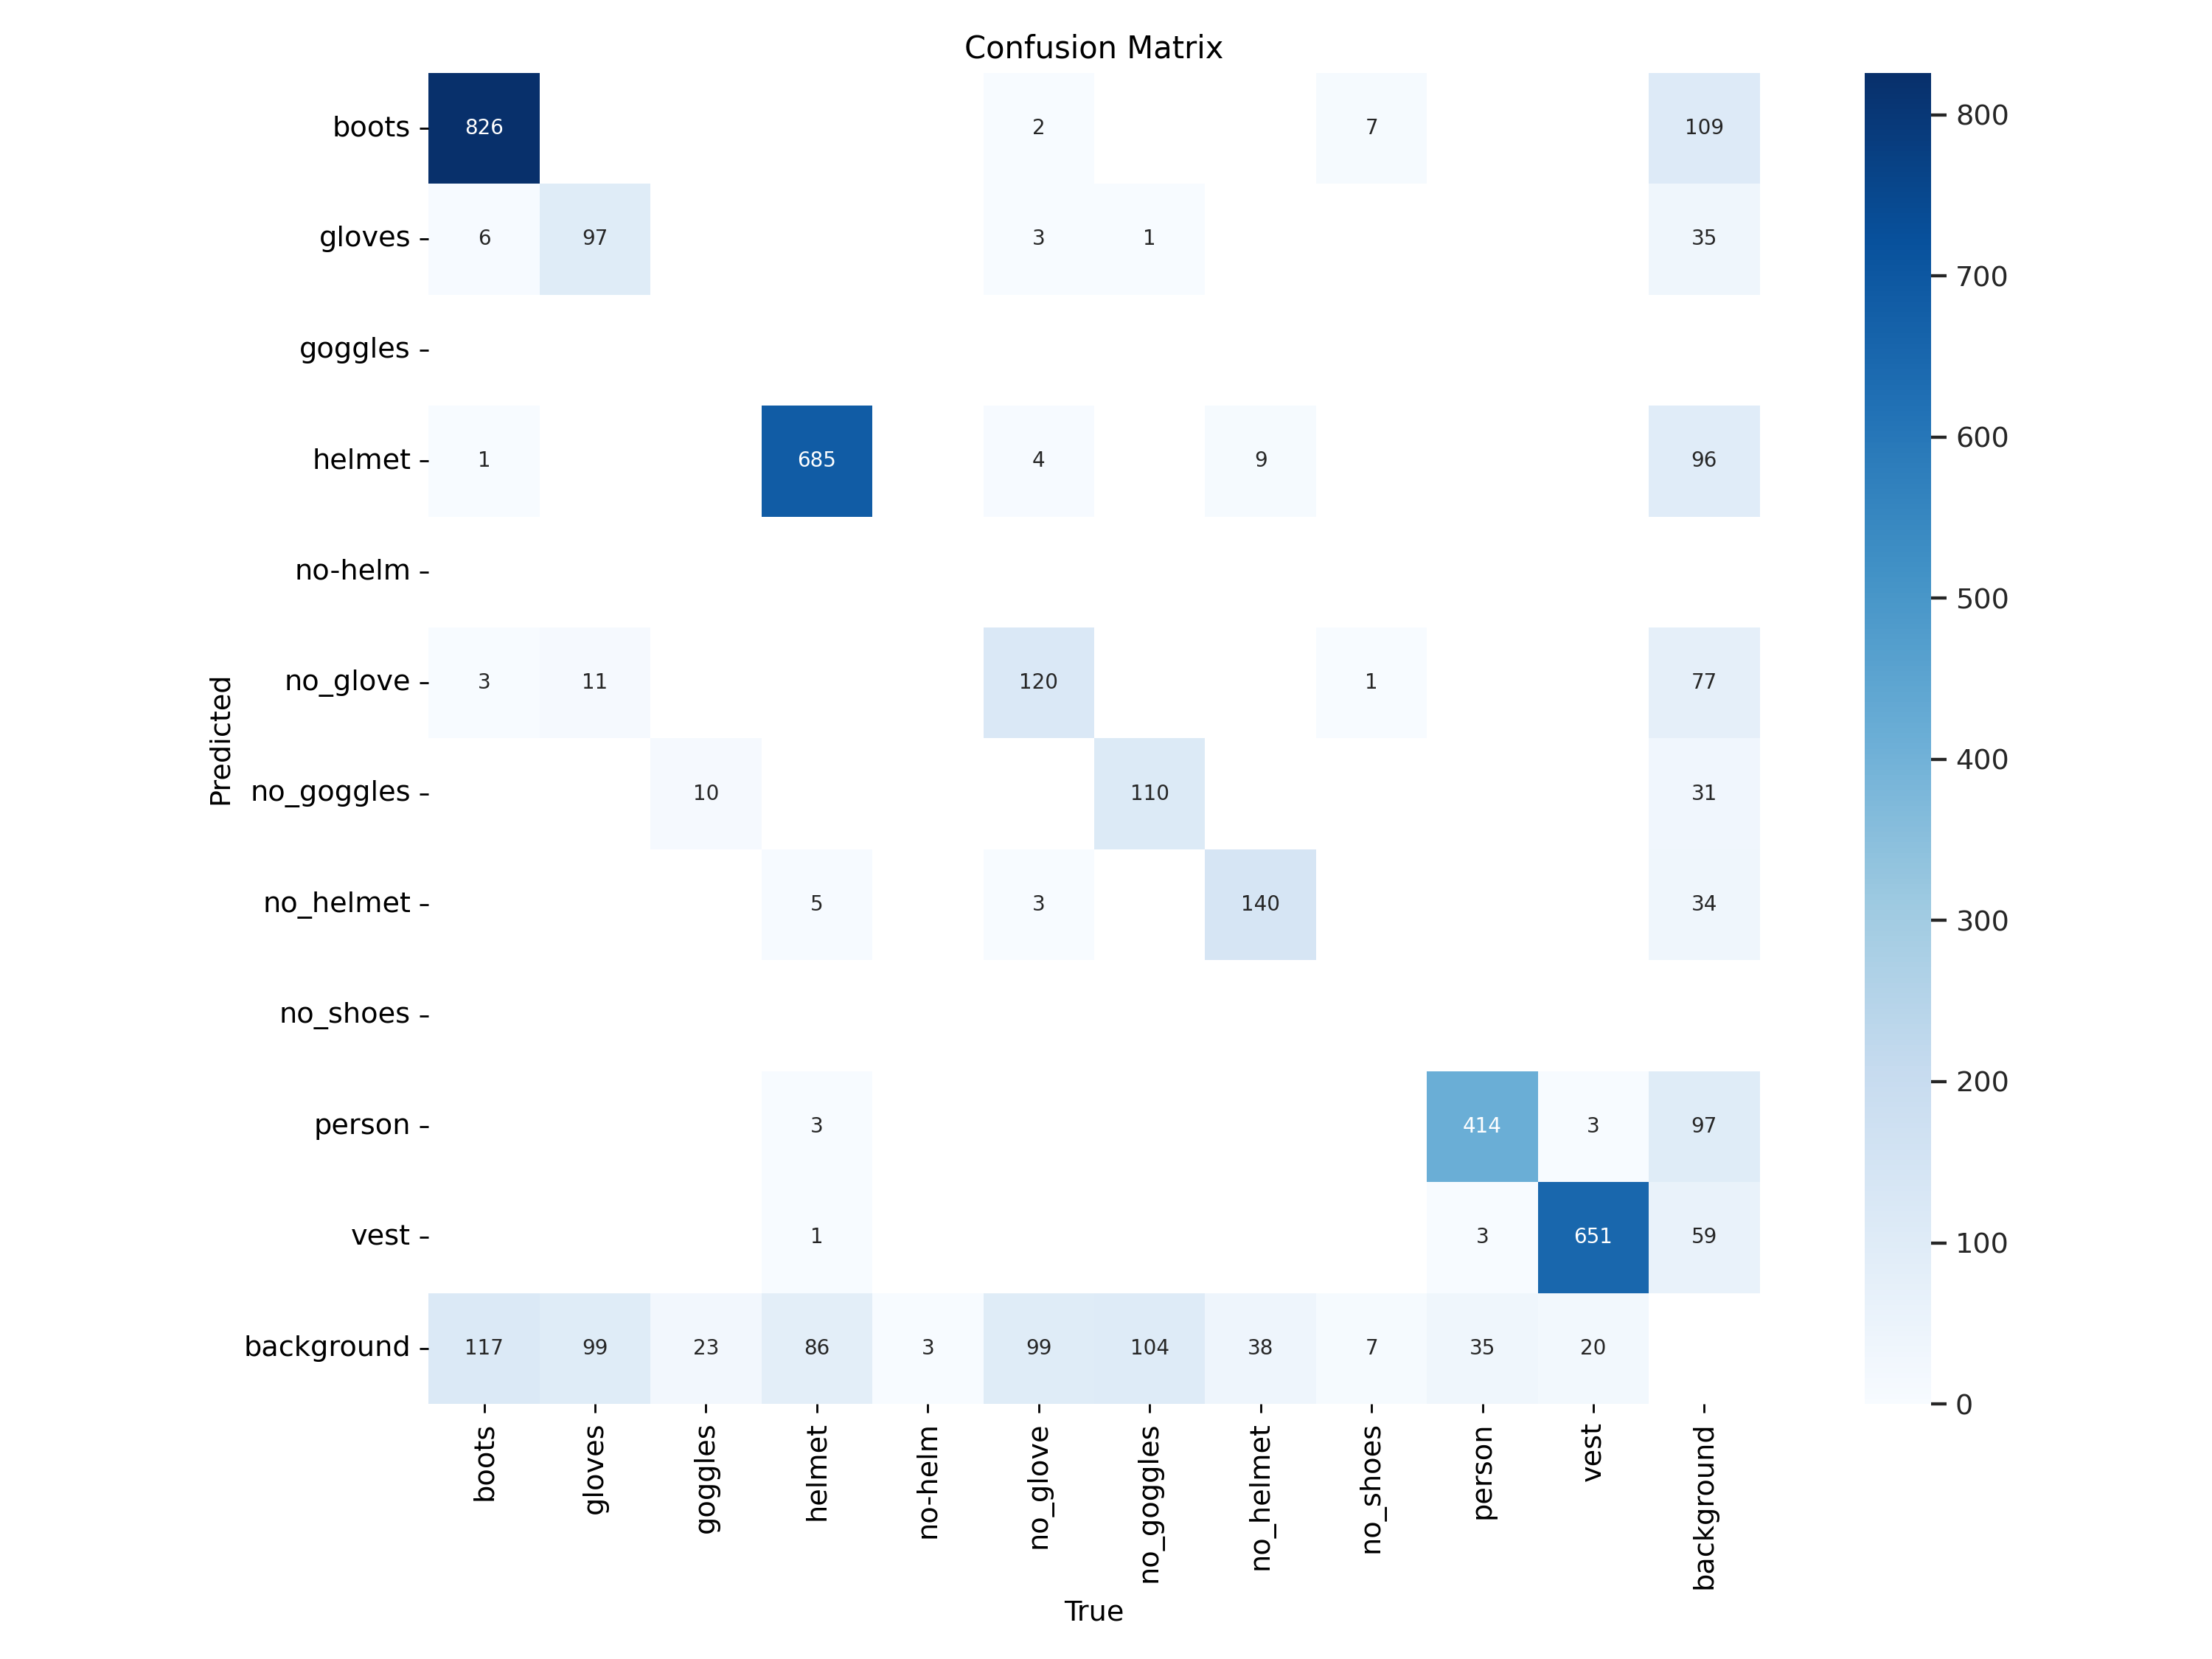

In [ ]:
from IPython.display import Image

Image(filename='runs/detect/train/confusion_matrix.png', width=1000)

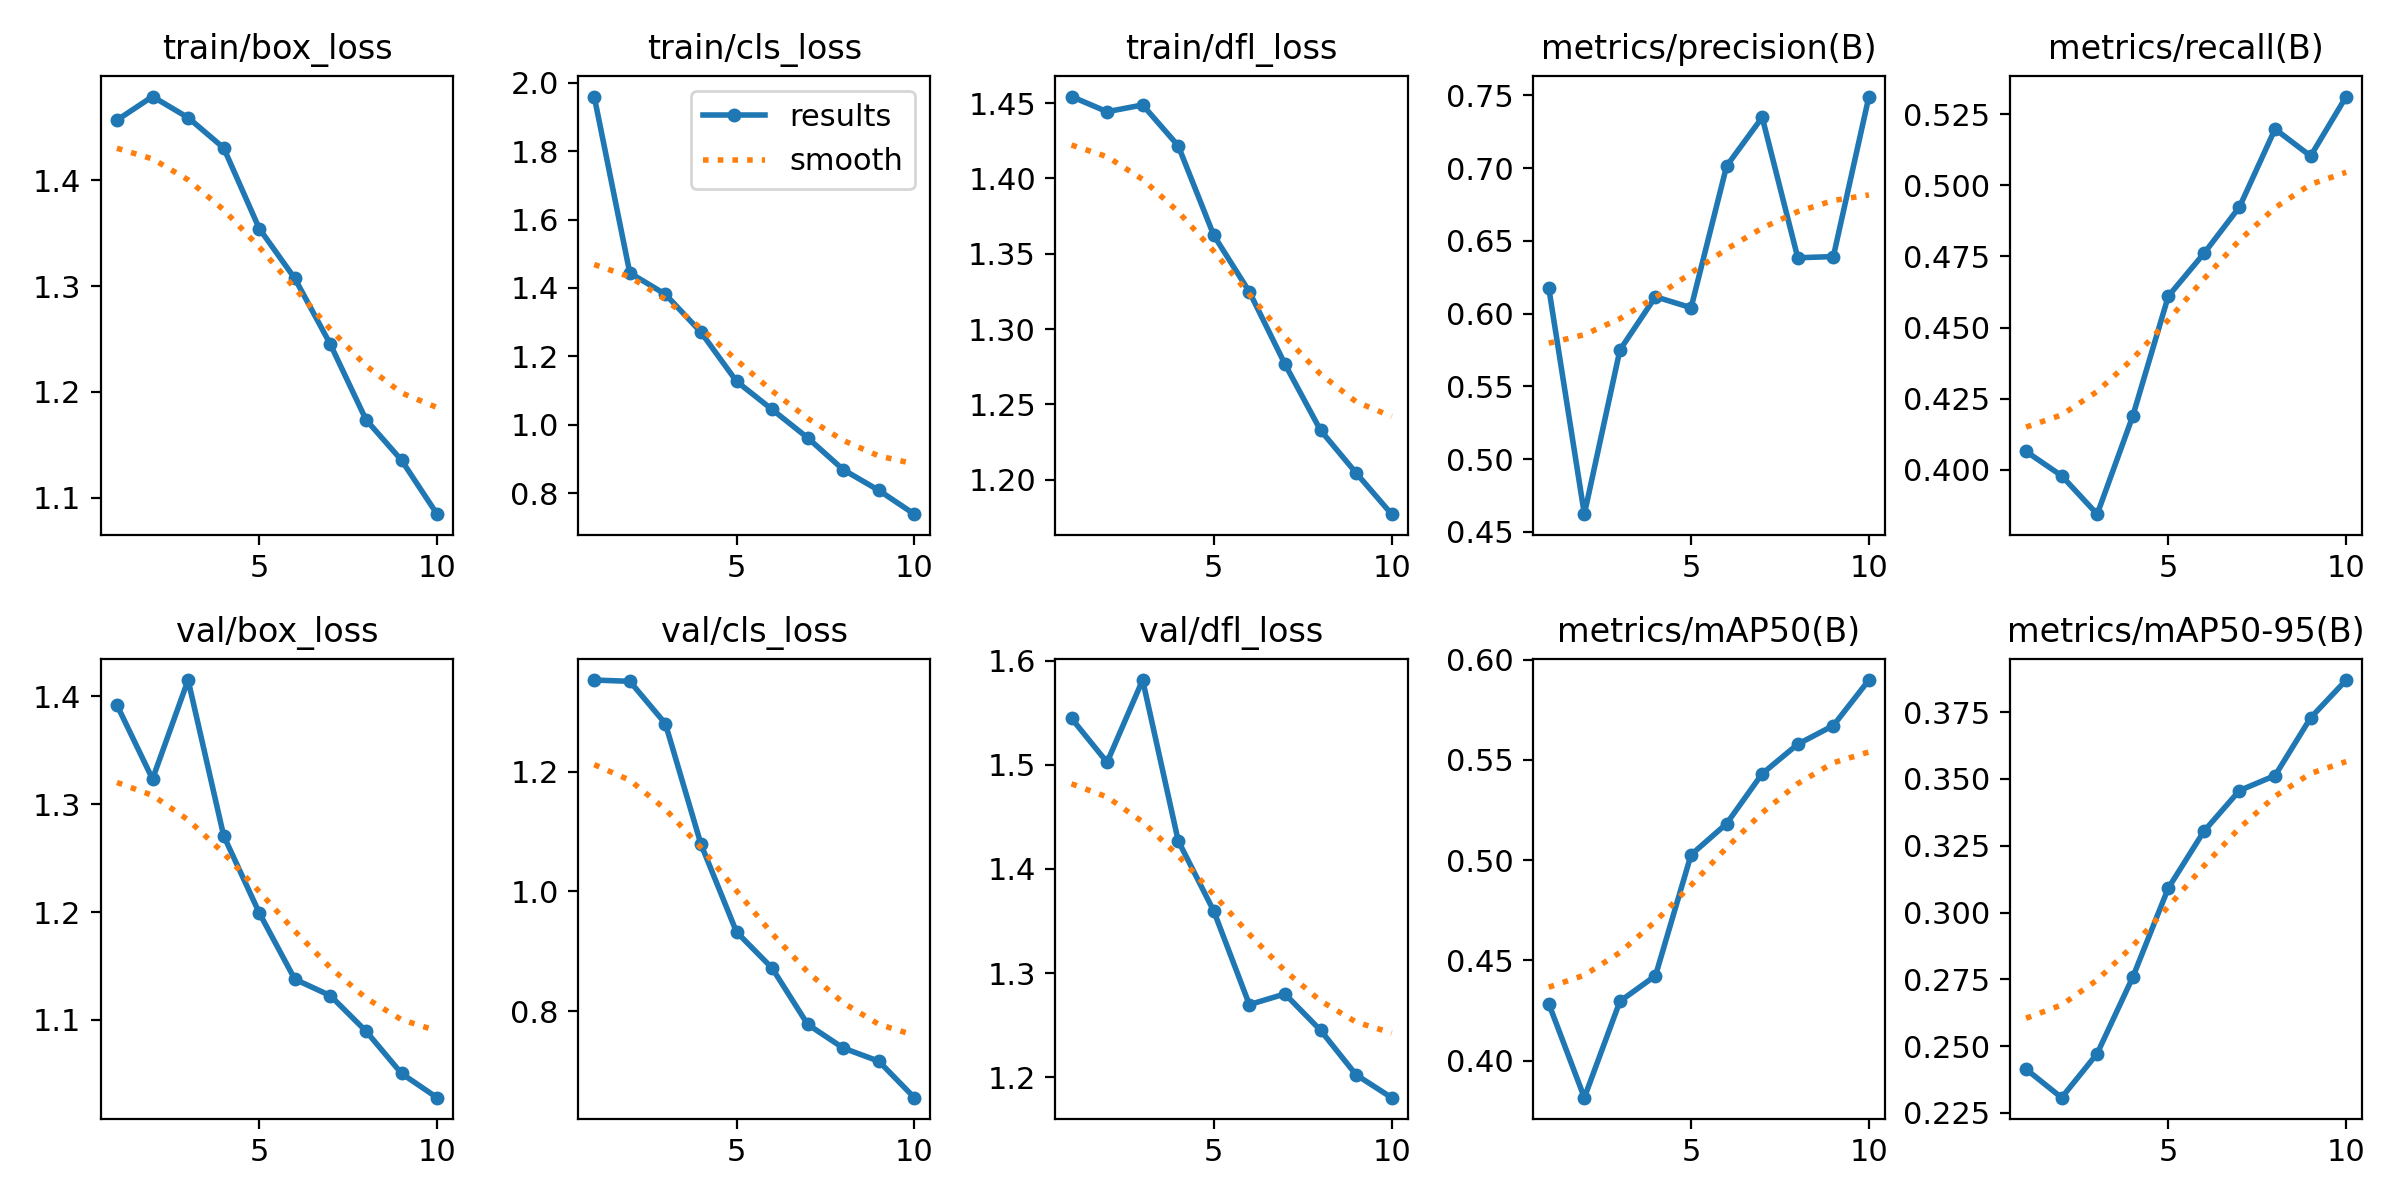

In [ ]:
from IPython.display import Image

Image(filename=f'runs/detect/train/results.png', width=1000)

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['boots',
 'gloves',
 'goggles',
 'helmet',
 'no-helm',
 'no_glove',
 'no_goggles',
 'no_helmet',
 'no_shoes',
 'person',
 'vest']

In [ ]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.21805798233413873
mAP 50 0.38966024823074746
mAP 75 0.20032558339426915


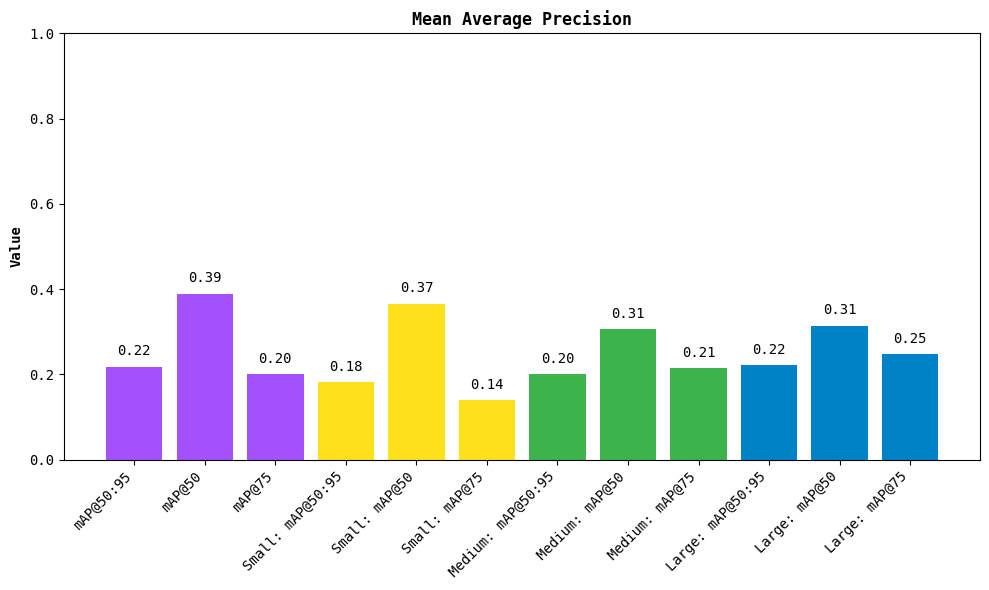

In [ ]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [ ]:
import supervision as sv

model = YOLO('runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

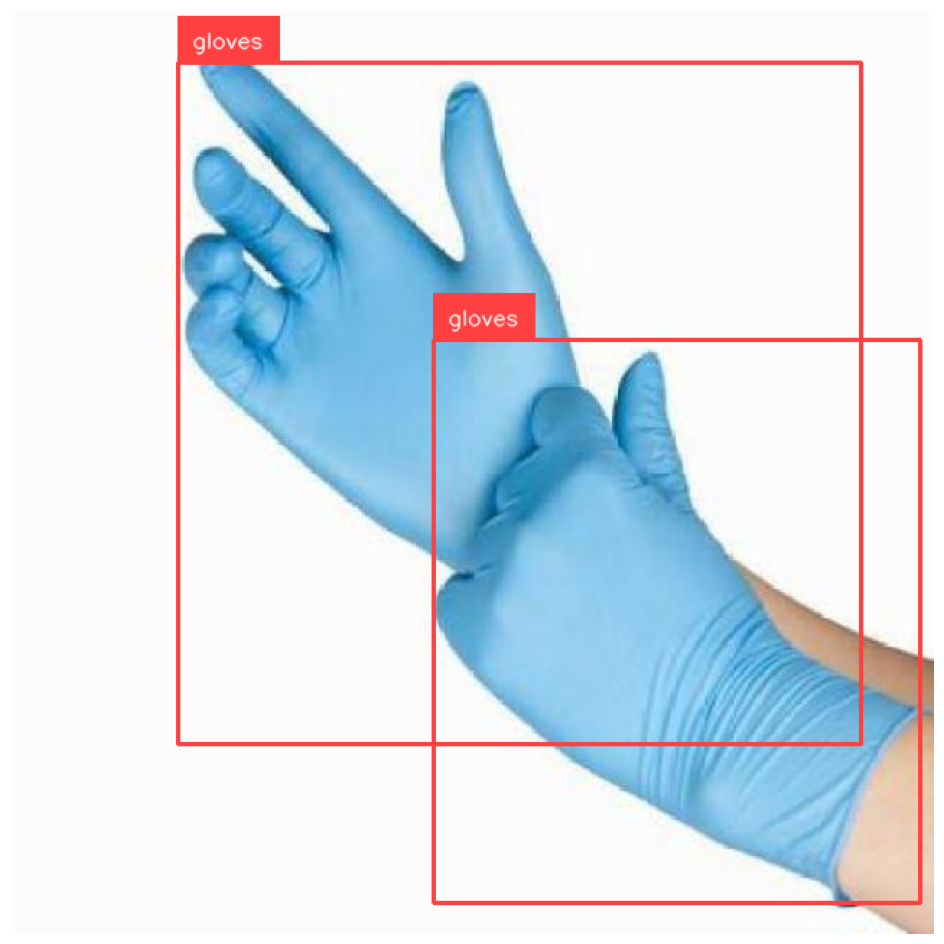

In [ ]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)